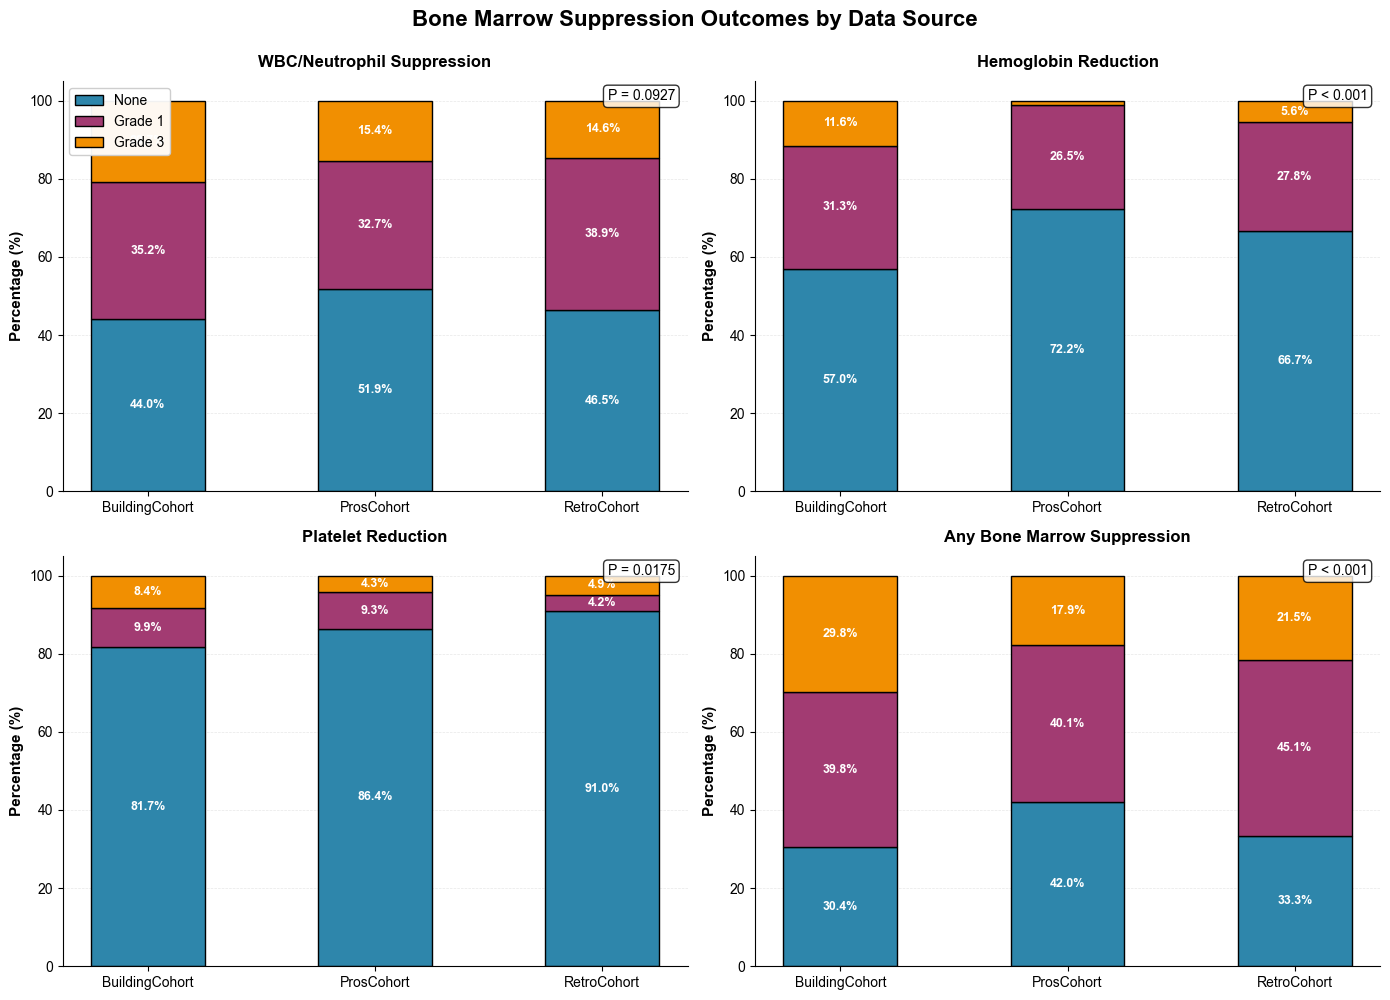

In [ ]:
# Baseline table and outcome plots generation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, f_oneway
from matplotlib import rcParams
from pathlib import Path

current_working_dir = Path.cwd()
data_file_path = current_working_dir.parent / "data" / "AllDataSets.parquet"
cohort = pd.read_parquet(data_file_path)

baseline_cols = ['age', 'gender', 'Center']
tnm_cols = ['c_t_stage', 'c_n_stage', 'c_m_stage', 'clinic_stage']
outcome_cols = [
    'suppression_WBC_Neut_1p', 'severe_suppression_WBC_Neut_3p',
    'suppression_Hb_1p', 'severe_suppression_Hb_3p',
    'suppression_PLT_1p', 'severe_suppression_PLT_3p',
    'any_suppression_1p', 'any_severe_suppression_3p'
]

cols_to_extract = ['patient_sn', 'data_source'] + baseline_cols + tnm_cols + outcome_cols
cohort_subset = cohort[cols_to_extract].copy()

agg_rules = {
    'age': 'first',
    'gender': 'first',
    'Center': 'first',
    'data_source': 'first',
    **{c: 'first' for c in tnm_cols},
    **{c: 'max' for c in outcome_cols}
}
cohort_patient_level = cohort_subset.groupby('patient_sn').agg(agg_rules).reset_index()

def create_baseline_table_en(df, group_col='data_source'):
    continuous_vars = ['age']
    categorical_vars = ['gender', 'c_t_stage', 'c_n_stage', 'c_m_stage', 'clinic_stage']
    outcome_vars = outcome_cols

    groups = sorted(df[group_col].unique())
    baseline_data = []

    for var in continuous_vars:
        row = {'Variable': 'Age', 'Category': 'Mean±SD'}
        for group in groups:
            group_data = df[df[group_col] == group][var]
            row[group] = f"{group_data.mean():.1f}±{group_data.std():.1f}"
        f_stat, p_val = f_oneway(*[df[df[group_col] == g][var].values for g in groups])
        row['P value'] = f"{p_val:.4f}" if p_val > 0.0001 else "<0.0001"
        baseline_data.append(row)

    var_labels = {
        'gender': 'Sex',
        'c_t_stage': 'cT Stage',
        'c_n_stage': 'cN Stage',
        'c_m_stage': 'cM Stage',
        'clinic_stage': 'Clinical Stage'
    }
    value_labels = {
        'Female': 'Female', 'Male': 'Male',
        'cT1': 'cT1', 'cT2': 'cT2', 'cT3': 'cT3', 'cT4': 'cT4',
        'cN0': 'cN0', 'cN1': 'cN1', 'cN2': 'cN2', 'cN3': 'cN3',
        'cM0': 'cM0', 'cM1': 'cM1',
        'I': 'Stage I', 'II': 'Stage II', 'III': 'Stage III', 'IV': 'Stage IV',
        'unknown': 'Unknown'
    }

    for var in categorical_vars:
        categories = sorted(df[var].dropna().unique())
        row = {'Variable': var_labels.get(var, var), 'Category': ''}
        row.update({g: '' for g in groups})
        row['P value'] = ''
        baseline_data.append(row)

        contingency_data = []
        for cat in categories:
            row = {'Variable': '', 'Category': value_labels.get(str(cat), str(cat))}
            for group in groups:
                count = ((df[group_col] == group) & (df[var] == cat)).sum()
                total = (df[group_col] == group).sum()
                pct = count / total * 100 if total > 0 else 0
                row[group] = f"{int(count)} ({pct:.1f}%)"
                contingency_data.append([group, cat, count])
            baseline_data.append(row)

        if len(categories) > 1:
            cont_table = pd.DataFrame(contingency_data, columns=[group_col, var, 'count'])
            cont_pivot = cont_table.pivot_table(index=var, columns=group_col, values='count', fill_value=0)
            chi2, p_val, dof, expected = chi2_contingency(cont_pivot)
            baseline_data[-len(categories)]['P value'] = f"{p_val:.4f}" if p_val > 0.0001 else "<0.0001"

    outcome_labels = {
        'suppression_WBC_Neut_1p': 'Grade ≥1 WBC/Neut Suppression',
        'severe_suppression_WBC_Neut_3p': 'Grade ≥3 WBC/Neut Suppression',
        'suppression_Hb_1p': 'Grade ≥1 Hemoglobin Reduction',
        'severe_suppression_Hb_3p': 'Grade ≥3 Hemoglobin Reduction',
        'suppression_PLT_1p': 'Grade ≥1 Platelet Reduction',
        'severe_suppression_PLT_3p': 'Grade ≥3 Platelet Reduction',
        'any_suppression_1p': 'Any Grade ≥1 Bone Marrow Suppression',
        'any_severe_suppression_3p': 'Any Grade ≥3 Bone Marrow Suppression'
    }

    baseline_data.append({'Variable': 'Outcomes', 'Category': '', 'P value': '', **{g: '' for g in groups}})

    for var in outcome_vars:
        row = {'Variable': '', 'Category': outcome_labels.get(var, var)}
        for group in groups:
            count = ((df[group_col] == group) & (df[var] == 1)).sum()
            total = (df[group_col] == group).sum()
            pct = count / total * 100 if total > 0 else 0
            row[group] = f"{int(count)} ({pct:.1f}%)"
        contingency = []
        for group in groups:
            yes = ((df[group_col] == group) & (df[var] == 1)).sum()
            no = ((df[group_col] == group) & (df[var] == 0)).sum()
            contingency.append([yes, no])
        chi2, p_val, dof, expected = chi2_contingency(contingency)
        row['P value'] = f"{p_val:.4f}" if p_val > 0.0001 else "<0.0001"
        baseline_data.append(row)

    return pd.DataFrame(baseline_data)

baseline_table_en = create_baseline_table_en(cohort_patient_level, group_col='data_source')

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42

def prepare_outcome_data(df, col_1p, col_3p):
    data_by_source = {}
    for source in sorted(df['data_source'].unique()):
        source_data = df[df['data_source'] == source]
        no_event = ((source_data[col_1p] == 0) & (source_data[col_3p] == 0)).sum()
        grade1_only = ((source_data[col_1p] == 1) & (source_data[col_3p] == 0)).sum()
        grade3 = (source_data[col_3p] == 1).sum()
        total = len(source_data)
        data_by_source[source] = {
            'None': no_event / total * 100,
            'Grade 1': grade1_only / total * 100,
            'Grade 3': grade3 / total * 100
        }
    contingency_table = []
    for source in sorted(data_by_source.keys()):
        source_data = df[df['data_source'] == source]
        no = ((source_data[col_1p] == 0) & (source_data[col_3p] == 0)).sum()
        mild = ((source_data[col_1p] == 1) & (source_data[col_3p] == 0)).sum()
        severe = (source_data[col_3p] == 1).sum()
        contingency_table.append([no, mild, severe])
    chi2, p_val, dof, expected = chi2_contingency(contingency_table)
    return data_by_source, p_val

outcomes = [
    ('suppression_WBC_Neut_1p', 'severe_suppression_WBC_Neut_3p', 'WBC/Neutrophil Suppression'),
    ('suppression_Hb_1p', 'severe_suppression_Hb_3p', 'Hemoglobin Reduction'),
    ('suppression_PLT_1p', 'severe_suppression_PLT_3p', 'Platelet Reduction'),
    ('any_suppression_1p', 'any_severe_suppression_3p', 'Any Bone Marrow Suppression')
]

outcome_data = {}
outcome_pvalues = {}
for col_1p, col_3p, title in outcomes:
    data, p_val = prepare_outcome_data(cohort_patient_level, col_1p, col_3p)
    outcome_data[title] = data
    outcome_pvalues[title] = p_val

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Bone Marrow Suppression Outcomes by Data Source', fontsize=16, fontweight='bold', y=0.995)

colors = ['#2E86AB', '#A23B72', '#F18F01']
categories = ['None', 'Grade 1', 'Grade 3']
axes_flat = axes.flatten()

for idx, (col_1p, col_3p, title) in enumerate(outcomes):
    ax = axes_flat[idx]
    sources = sorted(outcome_data[title].keys())
    x_pos = np.arange(len(sources))
    width = 0.5

    none_pct = [outcome_data[title][s]['None'] for s in sources]
    grade1_pct = [outcome_data[title][s]['Grade 1'] for s in sources]
    grade3_pct = [outcome_data[title][s]['Grade 3'] for s in sources]

    ax.bar(x_pos, none_pct, width, label='None', color=colors[0], edgecolor='black', linewidth=1)
    ax.bar(x_pos, grade1_pct, width, bottom=none_pct, label='Grade 1', color=colors[1], edgecolor='black', linewidth=1)
    bottom_for_grade3 = [none_pct[i] + grade1_pct[i] for i in range(len(sources))]
    ax.bar(x_pos, grade3_pct, width, bottom=bottom_for_grade3, label='Grade 3', color=colors[2], edgecolor='black', linewidth=1)

    for i, source in enumerate(sources):
        y_offset = 0
        if none_pct[i] > 3:
            ax.text(i, y_offset + none_pct[i]/2, f"{none_pct[i]:.1f}%", ha='center', va='center', fontsize=9, fontweight='bold', color='white')
        y_offset += none_pct[i]
        if grade1_pct[i] > 3:
            ax.text(i, y_offset + grade1_pct[i]/2, f"{grade1_pct[i]:.1f}%", ha='center', va='center', fontsize=9, fontweight='bold', color='white')
        y_offset += grade1_pct[i]
        if grade3_pct[i] > 3:
            ax.text(i, y_offset + grade3_pct[i]/2, f"{grade3_pct[i]:.1f}%", ha='center', va='center', fontsize=9, fontweight='bold', color='white')

    p_val = outcome_pvalues[title]
    p_text = 'P < 0.001' if p_val < 0.001 else f'P = {p_val:.4f}'
    ax.text(0.98, 0.98, p_text, transform=ax.transAxes, fontsize=10, verticalalignment='top',
            horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black'))

    ax.set_ylabel('Percentage (%)', fontsize=11, fontweight='bold')
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(sources, fontsize=10)
    ax.set_ylim(0, 105)
    ax.grid(axis='y', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_axisbelow(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if idx == 0:
        ax.legend(categories, loc='upper left', frameon=True, fontsize=10, framealpha=0.95)

plt.tight_layout()
plt.show()

In [9]:
baseline_table_en

,Variable,Category,BuildingCohort,ProsCohort,RetroCohort,P value
0,Age,Mean±SD,46.2±11.3,50.9±10.8,49.2±12.0,<0.0001
1,Sex,,,,,
2,,Female,3056 (25.3%),43 (26.5%),28 (19.4%),0.2530
3,,Male,9009 (74.7%),119 (73.5%),116 (80.6%),NaN
4,cT Stage,,,,,
5,,cT1,464 (3.8%),14 (8.6%),4 (2.8%),<0.0001
6,,cT2,1310 (10.9%),49 (30.2%),21 (14.6%),NaN
7,,cT3,6687 (55.4%),68 (42.0%),55 (38.2%),NaN
8,,cT4,3146 (26.1%),31 (19.1%),48 (33.3%),NaN
9,,Unknown,458 (3.8%),0 (0.0%),16 (11.1%),NaN
